In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns
import matplotlib.ticker as mtick

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
K_set = 1
T_set = 10
I_set = 4

In [3]:
dem_dictionary_k = {1: [40000, 80000, 50000]
}

#define supply attributes
#capacity
cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
                     2: [10000,20000,15000], 
                     3: [13000,20000,17000],
                     4: [40000,100000,60000]}


#lead-time
lead_time_dictionary_supplier_SKU = {1: [3,5,4], #min, max, likely, a,b,c
                     2: [1,3,2], 
                     3: [3,5,4],
                     4: [0,2,0]}

#dynamic adj
dynamic_adj_dem = [0.5, 0.55, 0.6, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.85]
dynamic_adj_supply = np.zeros(T_set)
for t in range(1, T_set+1):
    if dynamic_adj_dem[t-1] < 1:
        dynamic_adj_supply[t-1] = 1+(1-dynamic_adj_dem[t-1])
    else:
        dynamic_adj_supply[t-1] = 2-dynamic_adj_dem[t-1]

budget = 700000
warehouse_cap_level = 1.5 #time intervals of expected supply needed that can be stored
reliability_level = .75
dynamic = False

#supplier-SKU names
names_supplier_SKU = ['Supplier 1 - SKU: N95-MG', 'Supplier 1 - SKU: N95-N', 
 'Supplier 2 - SKU: SUR-MG', 'Supplier 2 - SKU: SUR-N']

In [4]:
def triangular_dist_demand(a,b,c,prob):
    if prob <= (c-a)/(b-a):
        return(a+((((prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((1-prob)*(b-a)*(b-c))**(1/2)))

In [5]:
def triangular_dist_supply(a,b,c,prob):
    if 1-prob <= (c-a)/(b-a):
        return(a+((((1-prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((prob)*(b-a)*(b-c))**(1/2)))

In [6]:
def lead_time_dist(a,b,c):
    lead_time_dist_array = np.zeros(T_set+1)
    cum_prob = 0
    t = 0
    
    while t < b+1:
        if t+1 <= a:
            t = t+1 
        elif (a < t+1 & t+1 <= c):
            cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
        elif c < t+1 & t+1 <= b+1:
            cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
    
    return(lead_time_dist_array)

In [7]:
k = 1

#define parameters

###health care commodity metric parameters####
#rank
r_k_dict = {
    1 : 1
}

#quality 
q_k_i_dict = {
    tuple([1,1]) : 1.3,
    tuple([1,2]): 1.2,
    tuple([1,3]): 1.2,
    tuple([1,4]): 1.1
}


####Supply Parameters#####

#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}
for i in range(1,I_set+1):
    lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                         lead_time_dictionary_supplier_SKU.get(i)[1],
                                         lead_time_dictionary_supplier_SKU.get(i)[2])
    for t in range(0,T_set+1):
                f_k_i_tDiff_dict[tuple([k,i,t])] = lead_time_dist_array[t]


#incoming orders
o_k_i_t_dict = {}

for k in range(1,K_set+1):
    for i in range(1,I_set+1):
        for t in range(1,T_set+1):
            if t <= 2:
                o_k_i_t_dict[tuple([k,i,t])] = 0 #20000/4 #5000
            else:
                o_k_i_t_dict[tuple([k,i,t])] = 0



#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict = {}

for i in range(1,I_set+1):
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
    else:
        for t in range(1,T_set+1):
            CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp

####Demand Parameters####
n_k_init_dict = {
    1 : 0
}


#demand RV
D_k_t_dict = {}
demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                     dem_dictionary_k.get(k)[1],
                                     dem_dictionary_k.get(k)[2],
                                     reliability_level)

if (dynamic == True):
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_k_t_dict[tuple([k,t])] = demand_temp_2
else:
    for t in range(1,T_set+1):
        D_k_t_dict[tuple([k,t])] = demand_temp


#starting inventory
z_k_i_init_dict = {
    tuple([1,1]) : 80000/4,
    tuple([1,2]) : 80000/4,
    tuple([1,3]) : 80000/4,
    tuple([1,4]) : 80000/4
}

#size
s_k_dict = {
    1 : 1
}

#warehouse capacity
h = 80000*warehouse_cap_level 

#cost (supplier 2 has the lowest cost)
c_k_i_dict = {
    tuple([1,1]) : 2,
    tuple([1,2]) : 1.5,
    tuple([1,3]) : 1,
    tuple([1,4]) : .8
}

b = budget

In [8]:
input_data_dir = os.getcwd()+'/outputs/3_1_description_of_input_data'
appendix_b_dir = os.getcwd()+'/outputs/appendix_b'

In [9]:
#os.chdir('/Users/chelseagreene/github/epi_supplychain_optimization/inventory_management/model/publication/Final/outputs/appendix_b')

In [10]:
#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}
for i in range(1,I_set+1):
    lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                         lead_time_dictionary_supplier_SKU.get(i)[1],
                                         lead_time_dictionary_supplier_SKU.get(i)[2])
    for t in range(0,T_set+1):
                f_k_i_tDiff_dict[tuple([k,i,t])] = lead_time_dist_array[t]

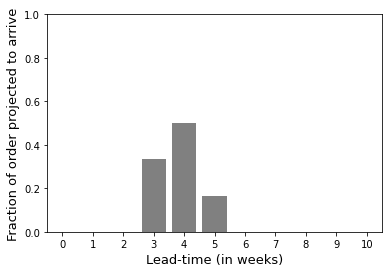

In [25]:
i = 1
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t])))

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = 'gray')
ax.set_xlabel('Lead-time (in weeks)', fontsize = 13)
ax.set_ylabel('Fraction of order projected to arrive', fontsize = 13)
ax.set(ylim=(0, 1))
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())


plot.savefig('lead_time_dist_N95MG.jpg')

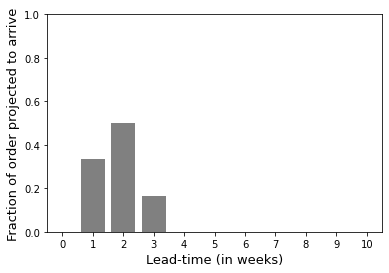

In [26]:
i = 2
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t])))

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = 'gray')
ax.set_xlabel('Lead-time (in weeks)', fontsize = 13)
ax.set_ylabel('Fraction of order projected to arrive', fontsize = 13)
ax.set(ylim=(0, 1))
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plot.savefig('lead_time_dist_N95Non.jpg')

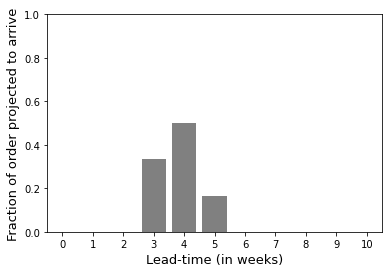

In [27]:
i = 3
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t])))

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = 'gray')
ax.set_xlabel('Lead-time (in weeks)', fontsize = 13)
ax.set_ylabel('Fraction of order projected to arrive', fontsize = 13)
ax.set(ylim=(0, 1))
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plot.savefig('lead_time_dist_SURMG.jpg')

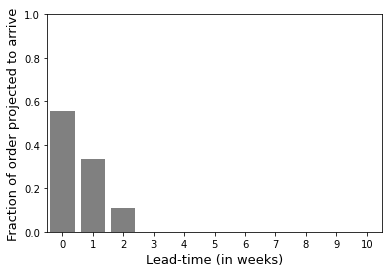

In [29]:
i = 4
temp = np.zeros(T_set+1)
for t in range(0,T_set+1):
    temp[t] = (f_k_i_tDiff_dict.get(tuple([1,i,t])))

fig, ax = plot.subplots(figsize=(6,4))
temp2 = pd.DataFrame()
temp2['Lead-Time Probability'] = temp
temp2['Ordering Period'] = np.arange(0,11,1)

sns.barplot(x="Ordering Period", y="Lead-Time Probability", data=temp2, color = 'gray')
ax.set_xlabel('Lead-time (in weeks)', fontsize = 13)
ax.set_ylabel('Fraction of order projected to arrive', fontsize = 13)
ax.set(ylim=(0, 1))
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plot.savefig('lead_time_dist_SURNon.jpg')

In [15]:
os.getcwd()

'/Users/chelseagreene/github/epi_supplychain_optimization/inventory_management/model/publication/decision_science'

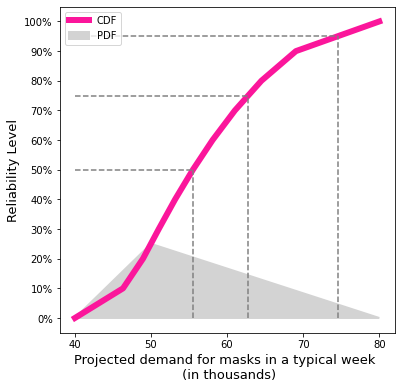

In [18]:
dem_min_likely_max = [40,50,80]
probs_min_likely_max = [0,25,100]

prob = np.arange(0,1.1,.1)
demanddist = np.zeros(len(prob))
counter = 0

prob_100 = [int(p * 100) for p in prob]

for p in prob:
    dem = dem_dictionary_k.get(1)
    demanddist[counter] = triangular_dist_demand(dem[0],dem[1],dem[2],p)
    counter = counter +1

fig, ax2 = plot.subplots(figsize=(6,6))
demanddist_1000 = [d/1000 for d in demanddist]

ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plot.plot(demanddist_1000, prob_100, 
          label='CDF', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
          linewidth=6,
          color = "#fb169b",
          zorder=1)

dem = [d/1000 for d in dem]

marker_probs = [.5, .75, .95]
marker_probs_100 = [int(p * 100) for p in marker_probs]

#plot.hlines(marker_probs_100, xmin = 40, xmax = 80, color = 'gray', linestyles = 'dashed')
#plot.vlines([55,62,74], ymin = 0, ymax = 100, color = 'gray', linestyles = 'dashed')
ax2.set_xticks(np.arange(40,90,10))
ax2.set_yticks(np.arange(0,110,10))
ax2.set_xlabel('Projected demand for masks in a typical week \n (in thousands)', fontsize = 13)
ax2.set_ylabel('Reliability Level', fontsize = 13)

#plot.scatter(dem_min_likely_max, probs_min_likely_max, marker = 'o', zorder=2, s = 100)
label_dem = ['min = 40', 'most-likely =50', 'max = 80']

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

shape = ['o', '*', "s"]

dem_min_likely_max = [40,50,80]
probs_min_likely_max = [0,25,0]

plot.fill(dem_min_likely_max, probs_min_likely_max, color = 'lightgray', 
          label='PDF',
          linewidth=2)

#for i in range(0,3):
#    ax2.scatter(dem_min_likely_max[i], probs_min_likely_max[i], zorder=2, 
#                 s = 200, color = 'black', marker = shape[i])
    #if i == 2:
    #    plot.text(dem_min_likely_max[i]-10, probs_min_likely_max[i], dem_min_likely_max[i], size = 13)#, bbox=props)
    #else:
    #    plot.text(dem_min_likely_max[i]+2, probs_min_likely_max[i], dem_min_likely_max[i], size = 13)#, bbox=props)

        
dem_rely = [demanddist[5], ((demanddist[7]+demanddist[8])/2), ((demanddist[9]+demanddist[10])/2)]
dem_rely = [d/1000 for d in dem_rely]
rely_probs = [50,75,95]

for i in range(0,3):
    #plot.scatter(dem_rely[i], rely_probs[i], zorder=2, s = 100, color = "grey")
    #plot.text(dem_rely[i]+1, rely_probs[i]-3, str(round(dem_rely[i],1)), size = 13)
    plot.hlines(marker_probs_100[i], xmin = 40, xmax = dem_rely[i], color = 'gray', linestyles = 'dashed')
    plot.vlines(dem_rely[i], ymin = 0, ymax = rely_probs[i], color = 'gray', 
                linestyles = 'dashed')
    #plot.text(40, rely_probs[i]+1, str(rely_probs[i]) +'% reliability = ' + str(int(dem_rely[i])), size = 12)

plot.legend(loc = 'upper left')

plot.savefig('demand_dist.jpg')

In [17]:
dem_rely

[55.50510257216823, 62.767200327080026, 74.52277442494834]

In [19]:
supplydist_1= np.zeros(len(prob))
supplydist_2= np.zeros(len(prob))
supplydist_3= np.zeros(len(prob))
supplydist_4= np.zeros(len(prob))

supplydist_1_markers= np.zeros(len(marker_probs))
supplydist_2_markers= np.zeros(len(marker_probs))
supplydist_3_markers= np.zeros(len(marker_probs))
supplydist_4_markers= np.zeros(len(marker_probs))

for i in range(1,I_set+1):
    cap = cap_dictionary_supplier_SKU.get(i)
    counter = 0
    for p in prob:
        if i == 1:
            global supplydist_1
            supplydist_1[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 2:
            global supplydist_2
            supplydist_2[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 3:
            global supplydist_3
            supplydist_3[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        else:
            global supplydist_4
            supplydist_4[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
            
            
for i in range(1,I_set+1):
    cap = cap_dictionary_supplier_SKU.get(i)
    counter = 0
    for p in marker_probs:
        if i == 1:
            supplydist_1_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 2:
            supplydist_2_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        elif i == 3:
            supplydist_3_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1
        else:
            supplydist_4_markers[counter] = triangular_dist_supply(cap[0], cap[1], cap[2], p)
            counter = counter + 1

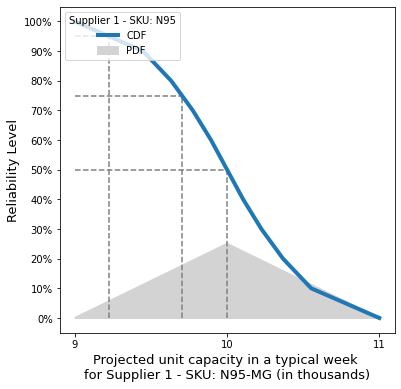

In [20]:
s1_min_likely_max = [9,10,11]
likely_prob = ((s1_min_likely_max[1]-s1_min_likely_max[0])/(s1_min_likely_max[2]-s1_min_likely_max[0]))
min_max_likely_prob = [0, likely_prob*100, 100]
min_max_likely_prob_s1 = min_max_likely_prob

fig, ax3 = plot.subplots(figsize=(6,6))
supplydist_1_1000 = [s/1000 for s in supplydist_1]


supplydist_1_markers_1000 = [s/1000 for s in supplydist_1_markers]

s1_rely = [supplydist_1_1000[5],
           ((supplydist_1_1000[7]+supplydist_1_1000[8])/2),
           ((supplydist_1_1000[9]+supplydist_1_1000[10])/2)]

ax3.yaxis.set_major_formatter(mtick.PercentFormatter())

pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]

for i in range(0,3):
    #plot.text(s1_rely[i]-.2, rely_probs[i]-4, str(round(s1_rely[i],1)), size = 13)
    plot.hlines(marker_probs_100[i], xmin = 9, xmax = s1_rely[i], color = 'gray', linestyles = 'dashed')
    plot.vlines(s1_rely[i], ymin = 0, ymax = rely_probs[i], color = 'gray', 
                linestyles = 'dashed')

plot.plot(supplydist_1_1000, prob_100, 
          color = pal[0], linewidth=4,
         label = 'CDF')

ax3.set_yticks(np.arange(0,110,10))
ax3.set_xticks(np.arange(9,12,1))
ax3.set_xlabel('Projected unit capacity in a typical week \nfor Supplier 1 - SKU: N95-MG (in thousands)', fontsize = 13)
ax3.set_ylabel('Reliability Level', fontsize = 13)

plot.fill(s1_min_likely_max, probs_min_likely_max, color = 'lightgray', 
          label='PDF',
          linewidth=2)

plot.legend(loc = 'upper left', title = 'Supplier 1 - SKU: N95')
plot.savefig('reliability_level_typical_estimates_N95MG.jpg')

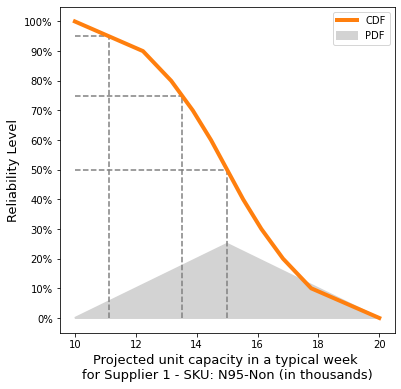

In [21]:
s2_min_likely_max = [10,15,20]
likely_prob = ((s2_min_likely_max[1]-s2_min_likely_max[0])/(s2_min_likely_max[2]-s2_min_likely_max[0]))
min_max_likely_prob = [0, likely_prob*100, 100]
min_max_likely_prob_s2 = min_max_likely_prob

fig, ax4 = plot.subplots(figsize=(6,6))
supplydist_2_1000 = [s/1000 for s in supplydist_2]

supplydist_2_markers_1000 = [s/1000 for s in supplydist_2_markers]


s2_rely = [supplydist_2_1000[5],
           ((supplydist_2_1000[7]+supplydist_2_1000[8])/2),
           ((supplydist_2_1000[9]+supplydist_2_1000[10])/2)]


ax4.yaxis.set_major_formatter(mtick.PercentFormatter())

pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]

plot.plot(supplydist_2_1000, prob_100, color = pal[1], linewidth=4, label = 'CDF')

ax4.set_yticks(np.arange(0,110,10))
ax4.set_xticks(np.arange(10,21,2))
ax4.set_xlabel('Projected unit capacity in a typical week \nfor Supplier 1 - SKU: N95-Non (in thousands)', fontsize = 13)
ax4.set_ylabel('Reliability Level', fontsize = 13)

for i in range(0,3):
    #plot.text(s2_rely[i]-1.1, rely_probs[i]-4, str(round(s2_rely[i],1)), size = 13)
    plot.hlines(marker_probs_100[i], xmin = 10, xmax = s2_rely[i], color = 'gray', linestyles = 'dashed')
    plot.vlines(s2_rely[i], ymin = 0, ymax = rely_probs[i], color = 'gray', 
                linestyles = 'dashed')

plot.fill(s2_min_likely_max, probs_min_likely_max, color = 'lightgray', 
          label='PDF',
          linewidth=2)


plot.legend()

plot.savefig('reliability_level_typical_estimates_N95Non.jpg')

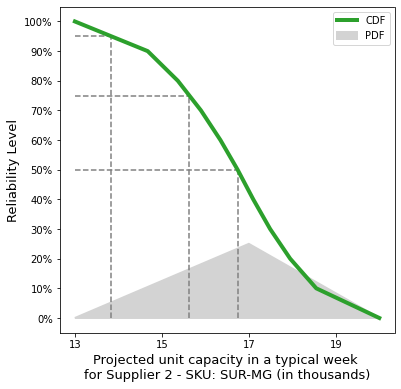

In [22]:
s3_min_likely_max = [13,17,20]
likely_prob = ((s3_min_likely_max[1]-s3_min_likely_max[0])/(s3_min_likely_max[2]-s3_min_likely_max[0]))
min_max_likely_prob = [0, likely_prob*100, 100]
min_max_likely_prob_s3 = min_max_likely_prob

fig, ax5 = plot.subplots(figsize=(6,6))
supplydist_3_1000 = [s/1000 for s in supplydist_3]

supplydist_3_markers_1000 = [s/1000 for s in supplydist_3_markers]

s3_rely = [supplydist_3_1000[5],
           ((supplydist_3_1000[7]+supplydist_3_1000[8])/2),
           ((supplydist_3_1000[9]+supplydist_3_1000[10])/2)]

ax5.yaxis.set_major_formatter(mtick.PercentFormatter())

pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
plot.plot(supplydist_3_1000, prob_100, color = pal[2], linewidth=4, label = 'CDF')

for i in range(0,3):
    #plot.text(s3_rely[i]-.9, rely_probs[i]-4, str(round(s3_rely[i],1)), size = 13)
    plot.hlines(marker_probs_100[i], xmin = s3_min_likely_max[0], xmax = s3_rely[i], color = 'gray', linestyles = 'dashed')
    plot.vlines(s3_rely[i], ymin = 0, ymax = rely_probs[i], color = 'gray', 
                linestyles = 'dashed')

plot.fill(s3_min_likely_max, probs_min_likely_max, color = 'lightgray', 
          label='PDF',
          linewidth=2)


ax5.set_yticks(np.arange(0,110,10))
ax5.set_xticks(np.arange(13,20,2))
ax5.set_xlabel('Projected unit capacity in a typical week \nfor Supplier 2 - SKU: SUR-MG (in thousands)', fontsize = 13)
ax5.set_ylabel('Reliability Level', fontsize = 13)

plot.legend()

plot.savefig('reliability_level_typical_estimates_SURMG.jpg')

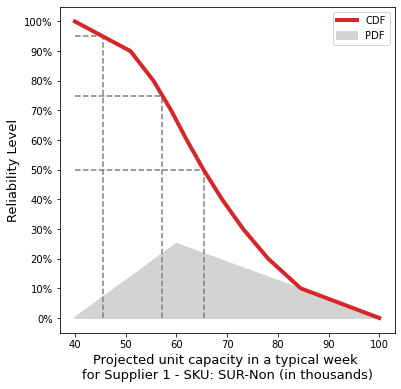

In [23]:
s4_min_likely_max = [40,60,100]
likely_prob = ((s4_min_likely_max[1]-s4_min_likely_max[0])/(s4_min_likely_max[2]-s4_min_likely_max[0]))
min_max_likely_prob = [0, likely_prob*100, 100]
min_max_likely_prob_s4 = min_max_likely_prob

fig, ax6 = plot.subplots(figsize=(6,6))
supplydist_4_1000 = [s/1000 for s in supplydist_4]

s4_rely = [supplydist_4_1000[5],
           ((supplydist_4_1000[7]+supplydist_4_1000[8])/2),
           ((supplydist_4_1000[9]+supplydist_4_1000[10])/2)]

supplydist_4_markers_1000 = [s/1000 for s in supplydist_4_markers]


ax6.yaxis.set_major_formatter(mtick.PercentFormatter())

pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
#plot.hlines(marker_probs_100, xmin = 40, xmax =100 , color = 'gray', linestyles = 'dashed')
plot.plot(supplydist_4_1000, prob_100, color = pal[3], linewidth=4, label = 'CDF')

ax6.set_yticks(np.arange(0,110,10))
ax6.set_xticks(np.arange(40,110,10))
ax6.set_xlabel('Projected unit capacity in a typical week \nfor Supplier 1 - SKU: SUR-Non (in thousands)', fontsize = 13)
ax6.set_ylabel('Reliability Level', fontsize = 13)

for i in range(0,3):
    #plot.text(s4_rely[i]-6, rely_probs[i]-4, str(round(s4_rely[i],1)), size = 13)
    plot.hlines(marker_probs_100[i], xmin = s4_min_likely_max[0], xmax = s4_rely[i], color = 'gray', linestyles = 'dashed')
    plot.vlines(s4_rely[i], ymin = 0, ymax = rely_probs[i], color = 'gray', 
                linestyles = 'dashed')


plot.fill(s4_min_likely_max, probs_min_likely_max, color = 'lightgray', 
          label='PDF',
          linewidth=2)

plot.legend()

plot.savefig('reliability_level_typical_estimates_SURNon.jpg')

In [ ]:
#lead time (supplier 1 has the higest capacity)
i = 1

CAP_t_s1_dict = {}


min_max_likely_prob_s1 = [.5, .75, .95, 0, min_max_likely_prob_s1[1], 1]

for rl in min_max_likely_prob_s1:
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      rl)
    for t in range(1,T_set+1):
        cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
        CAP_t_s1_dict[tuple([t,rl])] = cap_temp_2
            
dyn_cap_s1_df = pd.DataFrame(CAP_t_s1_dict.items(), columns=['sets', 'Supplier-SKU Unit Capacity'])
dyn_cap_s1_df.loc[:,'ordering_period']=dyn_cap_s1_df.sets.map(lambda x:x[0])
dyn_cap_s1_df.loc[:,'reliability_level']=dyn_cap_s1_df.sets.map(lambda x:x[1])
#dyn_cap_50_df.loc[:,'supplier_sku']=dyn_cap_50_df.sets.map(lambda x:x[1])
#dyn_cap_50_df.loc[:,'Ordering Period']=dyn_cap_50_df.sets.map(lambda x:x[2])

In [ ]:
#lead time (supplier 1 has the higest capacity)
i = 2

CAP_t_s2_dict = {}


min_max_likely_prob_s2 = [.5, .75, .95, 0, min_max_likely_prob_s2[1], 1]

for rl in min_max_likely_prob_s2:
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      rl)
    for t in range(1,T_set+1):
        cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
        CAP_t_s2_dict[tuple([t,rl])] = cap_temp_2
            
dyn_cap_s2_df = pd.DataFrame(CAP_t_s2_dict.items(), columns=['sets', 'Supplier-SKU Unit Capacity'])
dyn_cap_s2_df.loc[:,'ordering_period']=dyn_cap_s2_df.sets.map(lambda x:x[0])
dyn_cap_s2_df.loc[:,'reliability_level']=dyn_cap_s2_df.sets.map(lambda x:x[1])

In [ ]:
#lead time (supplier 1 has the higest capacity)
i = 3

CAP_t_s3_dict = {}


min_max_likely_prob_s3 = [.5, .75, .95, 0, min_max_likely_prob_s3[1], 1]

for rl in min_max_likely_prob_s3:
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      rl)
    for t in range(1,T_set+1):
        cap_temp_3 = cap_temp*dynamic_adj_supply[t-1]
        CAP_t_s3_dict[tuple([t,rl])] = cap_temp_3
            
dyn_cap_s3_df = pd.DataFrame(CAP_t_s3_dict.items(), columns=['sets', 'Supplier-SKU Unit Capacity'])
dyn_cap_s3_df.loc[:,'ordering_period']=dyn_cap_s3_df.sets.map(lambda x:x[0])
dyn_cap_s3_df.loc[:,'reliability_level']=dyn_cap_s3_df.sets.map(lambda x:x[1])

In [ ]:
#lead time (supplier 1 has the higest capacity)
i = 4

CAP_t_s4_dict = {}


min_max_likely_prob_s4 = [.5, .75, .95, 0, min_max_likely_prob_s4[1], 1]

for rl in min_max_likely_prob_s4:
    cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                      cap_dictionary_supplier_SKU.get(i)[1],
                                      cap_dictionary_supplier_SKU.get(i)[2],
                                      rl)
    for t in range(1,T_set+1):
        cap_temp_4 = cap_temp*dynamic_adj_supply[t-1]
        CAP_t_s4_dict[tuple([t,rl])] = cap_temp_4
            
dyn_cap_s4_df = pd.DataFrame(CAP_t_s4_dict.items(), columns=['sets', 'Supplier-SKU Unit Capacity'])
dyn_cap_s4_df.loc[:,'ordering_period']=dyn_cap_s4_df.sets.map(lambda x:x[0])
dyn_cap_s4_df.loc[:,'reliability_level']=dyn_cap_s4_df.sets.map(lambda x:x[1])

In [ ]:
line_styles = ['+', 'o', 's']
mfc_temp = [pal[0],'none',pal[0]]

col = sns.color_palette("mako",len(set(dyn_cap_s1_df['reliability_level'])))

fig, ax50 = plot.subplots(figsize=(8,6))

dyn_cap_s1_df['1000cap'] = dyn_cap_s1_df['Supplier-SKU Unit Capacity']/1000

n = 0

for rl in set(dyn_cap_s1_df['reliability_level']):
    
    if rl == 0:
        label_temp = 'min'
    
    if rl == 1:
        label_temp = 'max'
        
    if rl == .5:
        label_temp = '50%'
        
    if rl == .75:
        label_temp = '75%'
    
    if rl == .95:
        label_temp = '95%'
    
    if ((rl>0) and (rl<1)):
        plot.plot(dyn_cap_s1_df[dyn_cap_s1_df['reliability_level'] == rl]['ordering_period'],
                  dyn_cap_s1_df[dyn_cap_s1_df['reliability_level'] == rl]['1000cap'],
                  line_styles[n],
                  mfc=mfc_temp[n],
                  color = pal[0], 
                  linewidth=2,
                  label = label_temp)
        
        n = n+1
    else:
        plot.fill_between(dyn_cap_s1_df[dyn_cap_s1_df['reliability_level'] == rl]['ordering_period'],
                          dyn_cap_s1_df[dyn_cap_s1_df['reliability_level'] == 0]['1000cap'], 
                          dyn_cap_s1_df[dyn_cap_s1_df['reliability_level'] == 1]['1000cap'],
                         color = 'lightgrey')
        



ax50.set_xlabel('Ordering period (week)', fontsize = 13)
ax50.set_ylabel('Projected unit capacity (in thousands)\n'+'$cap^\epsilon_{i,t}, i = 1,~t \in \mathcal{T}, \epsilon \in$' +'{50%,75%,95%}', fontsize = 13)
                
                
                #'$d^\epsilon_{k,t}~for~k = 1,~t \in \mathcal{T}, \epsilon \in {50%,75%,95%}$'+ '\n for Supplier  1 - SKU: N95-MG', fontsize = 13)
ax50.set_xticks(np.arange(1,11,1))
ax50.set_yticks(np.arange(0,18,2))
#ax50.set(ylim=(0, 100), xlim=(0, 11))
#ax50.set_yticks(np.arange(0,130,10))

plot.legend(title = 'Reliability Level')
plot.savefig('s1_overtime.jpg')

In [ ]:
mfc_temp = [pal[1],'none',pal[1]]
fig, ax75 = plot.subplots(figsize=(8,6))

dyn_cap_s2_df['1000cap'] = dyn_cap_s2_df['Supplier-SKU Unit Capacity']/1000

n = 0

for rl in set(dyn_cap_s2_df['reliability_level']):
    
    if rl == 0:
        label_temp = 'min'
    
    if rl == 1:
        label_temp = 'max'
        
    if rl == .5:
        label_temp = '50%'
        
    if rl == .75:
        label_temp = '75%'
    
    if rl == .95:
        label_temp = '95%'
    
    if ((rl>0) and (rl<1)):
        plot.plot(dyn_cap_s2_df[dyn_cap_s2_df['reliability_level'] == rl]['ordering_period'],
                  dyn_cap_s2_df[dyn_cap_s2_df['reliability_level'] == rl]['1000cap'],
                  line_styles[n],
                  color = pal[1],
                  mfc = mfc_temp[n],
                  linewidth=2,
                  label = label_temp)
        
        n = n+1
    else:
        plot.fill_between(dyn_cap_s2_df[dyn_cap_s2_df['reliability_level'] == rl]['ordering_period'],
                          dyn_cap_s2_df[dyn_cap_s2_df['reliability_level'] == 0]['1000cap'], 
                          dyn_cap_s2_df[dyn_cap_s2_df['reliability_level'] == 1]['1000cap'],
                         color = 'lightgrey')
        



ax75.set_xlabel('Ordering period (week)', fontsize = 13)
ax75.set_ylabel('Projected unit capacity (in thousands)\n'+'$cap^\epsilon_{i,t}, i = 2,~t \in \mathcal{T}, \epsilon \in$' +'{50%,75%,95%}', fontsize = 13)

ax75.set_xticks(np.arange(1,11,1))
ax75.set_yticks(np.arange(0,32,2))
#ax50.set(ylim=(0, 100), xlim=(0, 11))
#ax50.set_yticks(np.arange(0,130,10))

plot.legend(title = 'Reliability Level')
plot.savefig('s2_overtime.jpg')

In [ ]:
fig, ax100 = plot.subplots(figsize=(8,6))

dyn_cap_s3_df['1000cap'] = dyn_cap_s3_df['Supplier-SKU Unit Capacity']/1000
mfc_temp = [pal[2],'none',pal[2]]

n = 0

for rl in set(dyn_cap_s3_df['reliability_level']):
    
    if rl == 0:
        label_temp = 'min'
    
    if rl == 1:
        label_temp = 'max'
        
    if rl == .5:
        label_temp = '50%'
        
    if rl == .75:
        label_temp = '75%'
    
    if rl == .95:
        label_temp = '95%'
    
    if ((rl>0) and (rl<1)):
        plot.plot(dyn_cap_s3_df[dyn_cap_s3_df['reliability_level'] == rl]['ordering_period'],
                  dyn_cap_s3_df[dyn_cap_s3_df['reliability_level'] == rl]['1000cap'],
                  line_styles[n],
                  color = pal[2],
                  mfc = mfc_temp[n],
                  label = label_temp)
        
        n = n+1
    else:
        plot.fill_between(dyn_cap_s3_df[dyn_cap_s3_df['reliability_level'] == rl]['ordering_period'],
                          dyn_cap_s3_df[dyn_cap_s3_df['reliability_level'] == 0]['1000cap'], 
                          dyn_cap_s3_df[dyn_cap_s3_df['reliability_level'] == 1]['1000cap'],
                         color = 'lightgrey')
        



ax100.set_xlabel('Ordering period (week)', fontsize = 13)
ax100.set_ylabel('Projected unit capacity (in thousands)\n'+'$cap^\epsilon_{i,t}, i = 3,~t \in \mathcal{T}, \epsilon \in$' +'{50%,75%,95%}', fontsize = 13)


ax100.set_xticks(np.arange(1,11,1))
ax100.set_yticks(np.arange(0,32,2))
#ax50.set(ylim=(0, 100), xlim=(0, 11))
#ax50.set_yticks(np.arange(0,130,10))

plot.legend(title = 'Reliability Level')
plot.savefig('s3_overtime.jpg')

In [ ]:
fig, ax175 = plot.subplots(figsize=(8,6))

mfc_temp = [pal[3],'none',pal[3]]

dyn_cap_s4_df['1000cap'] = dyn_cap_s4_df['Supplier-SKU Unit Capacity']/1000

n = 0

for rl in set(dyn_cap_s4_df['reliability_level']):
    
    if rl == 0:
        label_temp = 'min'
    
    if rl == 1:
        label_temp = 'max'
        
    if rl == .5:
        label_temp = '50%'
        
    if rl == .75:
        label_temp = '75%'
    
    if rl == .95:
        label_temp = '95%'
    
    if ((rl>0) and (rl<1)):
        plot.plot(dyn_cap_s4_df[dyn_cap_s4_df['reliability_level'] == rl]['ordering_period'],
                  dyn_cap_s4_df[dyn_cap_s4_df['reliability_level'] == rl]['1000cap'],
                  line_styles[n],
                  color = pal[3],
                  mfc = mfc_temp[n],
                  linewidth=2,
                  label = label_temp)
        
        n = n+1
    else:
        plot.fill_between(dyn_cap_s4_df[dyn_cap_s4_df['reliability_level'] == rl]['ordering_period'],
                          dyn_cap_s4_df[dyn_cap_s4_df['reliability_level'] == 0]['1000cap'], 
                          dyn_cap_s4_df[dyn_cap_s4_df['reliability_level'] == 1]['1000cap'],
                         color = 'lightgrey')
        



ax175.set_xlabel('Ordering period (week)', fontsize = 13)
ax175.set_ylabel('Projected unit capacity (in thousands)\n'+'$cap^\epsilon_{i,t}, i = 4,~t \in \mathcal{T}, \epsilon \in$' +'{50%,75%,95%}', fontsize = 13)

ax175.set_xticks(np.arange(1,11,1))
ax175.set_yticks(np.arange(0,160+10,10))
#ax50.set(ylim=(0, 100), xlim=(0, 11))
#ax50.set_yticks(np.arange(0,130,10))

plot.legend(title = 'Reliability Level')
plot.savefig('s4_overtime.jpg')

In [ ]:
dynamic = True
D_t_dict = {}
k = 1

min_max_likely_prob_d = [.5, .75, .95, 0, .25, 1]

for rl in min_max_likely_prob_d:
    demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                         dem_dictionary_k.get(k)[1],
                                         dem_dictionary_k.get(k)[2],
                                         rl)
    
    for t in range(1,T_set+1):
        demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
        D_t_dict[tuple([t, rl])] = demand_temp_2
        
dyn_dem_df = pd.DataFrame(D_t_dict.items(), columns=['sets', 'Demand'])
dyn_dem_df.loc[:,'ordering_period']=dyn_dem_df.sets.map(lambda x:x[0])
dyn_dem_df.loc[:,'reliability_level']=dyn_dem_df.sets.map(lambda x:x[1])

In [ ]:
fig, ax275 = plot.subplots(figsize=(8,6))
mfc_temp = ["#fb169b",'none',"#fb169b"]

dyn_dem_df['1000dem'] = dyn_dem_df['Demand']/1000
dyn_dem_df = dyn_dem_df[dyn_dem_df['reliability_level'] != .25]

n = 0

for rl in set(dyn_dem_df['reliability_level']):
    
    if rl == 0:
        label_temp = 'min'
    
    if rl == 1:
        label_temp = 'max'
        
    if rl == .5:
        label_temp = '50%'
        
    if rl == .75:
        label_temp = '75%'
    
    if rl == .95:
        label_temp = '95%'
    
    if ((rl>0) and (rl<1)):
        plot.plot(dyn_dem_df[dyn_dem_df['reliability_level'] == rl]['ordering_period'],
                  dyn_dem_df[dyn_dem_df['reliability_level'] == rl]['1000dem'],
                  line_styles[n],
                  color = "#fb169b",
                  mfc = mfc_temp[n],
                  linewidth=2,
                  label = label_temp)
        
        #plot.text(dyn_dem_df[dyn_dem_df['reliability_level'] == rl]['ordering_period'],
        #          dyn_dem_df[dyn_dem_df['reliability_level'] == rl]['1000dem'], 
        #          dyn_dem_df[dyn_dem_df['reliability_level'] == rl]['1000dem'], size = 13)
        
        n = n+1
    else:
        plot.fill_between(dyn_dem_df[dyn_dem_df['reliability_level'] == rl]['ordering_period'],
                          dyn_dem_df[dyn_dem_df['reliability_level'] == 0]['1000dem'], 
                          dyn_dem_df[dyn_dem_df['reliability_level'] == 1]['1000dem'],
                          color = 'lightgrey')
        

ax275.set_xlabel('Ordering period (week)', fontsize = 13)
ax275.set_ylabel('Projected incoming unit demand (in thousands) \n'+
                 '$d^\epsilon_{k,t}, k \in \mathcal{K},~t \in \mathcal{T}, \epsilon \in$' +'{50%,75%,95%}', fontsize = 13)
ax275.set_xticks(np.arange(1,11,1))
ax275.set_yticks(np.arange(0,max(dyn_dem_df['1000dem'])+10,10))
#ax50.set(ylim=(0, 100), xlim=(0, 11))
#ax50.set_yticks(np.arange(0,130,10))

plot.legend(title = 'Reliability Level')
plot.savefig('demand_overtime.jpg')